In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Y. Z.
"""
# import packages used in the project
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Predefined functions.
#---------------------------------------------------------------------------------------------------------#
# Function to generate power matrix.
#---------------------------------------------------------------------------------------------------------#
# Power states in varied time intervals are recorded and multiple operating sessions are stacked in a matrix.
# The arrays of starting and ending times, power states, and the number of time intervals are used as input.
# The output is the matrices containing all records for different sessions.
#---------------------------------------------------------------------------------------------------------#
def mat_pow(start_time_array, end_time_array, powe, num):
    l = len(start_time_array)
    record_mat = np.zeros((l, num))
    for i in range(l):
        if powe[i] != powe[i]:
            po = 0
        else:
            po = powe[i]
        if start_time_array[i] <= end_time_array[i]:
            record_mat[i, start_time_array[i]:end_time_array[i]] = po
        if start_time_array[i] > end_time_array[i]:
            record_mat[i, start_time_array[i]:] = po
            record_mat[i, :end_time_array[i]] = po
    return record_mat

#---------------------------------------------------------------------------------------------------------#
# Function to get normalized charging power.
#---------------------------------------------------------------------------------------------------------#
# The input is charging data of EVs in monthly-based format.
# The output is average charging power in designated normalization requirements.
#---------------------------------------------------------------------------------------------------------#
def mon_chg_power(data_chg_mon_tmp):
    vids_chg = data_chg_mon_tmp.veh_id.unique()
    vids_chg_mat_list = []
    for vid_tmp in vids_chg:
        data_chg_mon_vid_tmp = data_chg_mon_tmp.loc[data_chg_mon_tmp.veh_id == vid_tmp, :]
        mon_vid_unique_days = data_chg_mon_vid_tmp.start_time_dt.dt.day.unique()
        # print(len(mon_vid_unique_days), mon_vid_unique_days.tolist())
        # Convert temporal series to numpy array.
        start_time_array = data_chg_mon_vid_tmp.start_minute.values
        end_time_array =  data_chg_mon_vid_tmp.end_minute.values
        powe = data_chg_mon_vid_tmp.average_power.values
        # Get the record matrix for power in the time axis.
        chg_mat_wd = mat_pow(start_time_array, end_time_array, powe, 1440)
        chg_mat_sum_wd = chg_mat_wd.sum(axis=0)
        chg_mat_sum_wd = chg_mat_sum_wd / len(mon_vid_unique_days)
        vids_chg_mat_list.append(list(chg_mat_sum_wd))
    vids_chg_mat_arr = np.array(vids_chg_mat_list)
    chg_power_perCar_perDay = vids_chg_mat_arr.sum(axis=0) / len(vids_chg)
    return chg_power_perCar_perDay

#---------------------------------------------------------------------------------------------------------#
# Function to obtain EV numbers on the axis of time.
#---------------------------------------------------------------------------------------------------------#
# The input is real-world EV data with timestamps.
# The ouput is a matrix to record the occasions of EVs in varied times.
#---------------------------------------------------------------------------------------------------------#
def mat_minu(start_time_array, end_time_array, sta, num):
    l = len(start_time_array)
    record_mat = np.zeros((l, num))
    for i in range(l):
        if start_time_array[i] <= end_time_array[i]:
            record_mat[i, start_time_array[i]:end_time_array[i]] = 1
        if (start_time_array[i] > end_time_array[i]) & (sta==30):
            record_mat[i, start_time_array[i]:] = 1
            record_mat[i, :end_time_array[i]] = 1
    return record_mat

#---------------------------------------------------------------------------------------------------------#
# Function to calculate distributions of EV numbers in different time scale.
# Two operating modes are considered, i.e., driving and charging modes. 
#---------------------------------------------------------------------------------------------------------#
def month_oper_num(gb_drv_mon, gb_chg_mon):
    # Process EV data in driving sessions.
    vins_drv = gb_drv_mon.veh_id.unique()
    drv_week_num_list = []
    vins_drv_num = len(vins_drv)
    weekday_num_dict = {0:vins_drv_num* 7, 1:vins_drv_num* 7, 2:vins_drv_num* 7, 3:vins_drv_num* 7,
                        4:vins_drv_num* 7, 5:vins_drv_num* 7, 6:vins_drv_num* 7}
    # Compute varied vehicles.
    for vin_tmp in vins_drv:
        data_tmp = gb_drv_mon.loc[gb_drv_mon.veh_id == vin_tmp]
        drv_week = []
        weekday_num_list = []
        # Vehicles operate on different weekdays.
        for wd in np.arange(0, 7, 1):
            msk = data_tmp.start_time_dt.dt.weekday == wd
            data_tmp2 = data_tmp.loc[msk, :]
            if len(data_tmp2) == 0:
                drv_mat_sum_wd = np.zeros(1440)
                drv_week = drv_week + list(drv_mat_sum_wd)
                weekday_num_dict[wd] = weekday_num_dict[wd] - 1
                weekday_num_list = [1]
                continue
            # Aggregate weekly data.
            weekday_num = len(data_tmp2.start_time_dt.dt.day.unique())
            weekday_num_list.append(weekday_num)
            drv_mat_wd = mat_minu(data_tmp2.start_minute.values, data_tmp2.end_minute.values, 10, 1440)
            drv_mat_sum_wd = drv_mat_wd.sum(axis=0)/weekday_num
            drv_week = drv_week + list(drv_mat_sum_wd)
        drv_week = list(np.array(drv_week) * np.array(weekday_num_list).mean())
        drv_week_num_list.append(drv_week)
    # Combine weekly data for different vehicles.
    drv_week_num_arr = np.array(drv_week_num_list)
    drv_week_num_mean = drv_week_num_arr.sum(axis=0) / vins_drv_num
    for wd_tmp in np.arange(0, 7, 1):
        drv_week_num_mean[wd_tmp*1440:(wd_tmp+1)*1440] = \
            drv_week_num_mean[wd_tmp*1440:(wd_tmp+1)*1440] / weekday_num_dict[wd_tmp]
    drv_week_num_mean = drv_week_num_mean * np.array(list(weekday_num_dict.values())).mean()
    
    # Process EV data in charging sessions.
    vins_chg = gb_chg_mon.veh_id.unique()
    chg_week_num_list = []
    vins_chg_num = len(vins_chg)
    weekday_num_dict2 = {0:vins_chg_num * 7, 1:vins_chg_num* 7, 2:vins_chg_num* 7, 3:vins_chg_num* 7,
                        4:vins_chg_num* 7, 5:vins_chg_num* 7, 6:vins_chg_num* 7}
    # Compute varied vehicles.
    for vin_tmp in vins_drv:
        data_tmp = gb_chg_mon.loc[gb_chg_mon.veh_id == vin_tmp]
        chg_week = []
        weekday_num_list = []
        # Vehicles operate on different weekdays.
        for wd in np.arange(0, 7, 1):
            msk = data_tmp.start_time_dt.dt.weekday == wd
            data_tmp2 = data_tmp.loc[msk, :]
            if len(data_tmp2) == 0:
                chg_mat_sum_wd = np.zeros(1440)
                chg_week = chg_week + list(chg_mat_sum_wd)
                weekday_num_dict2[wd] = weekday_num_dict2[wd] - 1
                weekday_num_list = [1]
                continue
            # Aggregate weekly data.
            weekday_num_tmp = len(data_tmp2.start_time_dt.dt.day.unique())
            weekday_num_list.append(weekday_num_tmp)
            chg_mat_wd = mat_minu(data_tmp2.start_minute.values, data_tmp2.end_minute.values, 30, 1440)
            chg_mat_sum_wd = chg_mat_wd.sum(axis=0)/weekday_num_tmp
            chg_week = chg_week + list(chg_mat_sum_wd)
        chg_week = list(np.array(chg_week) * np.array(weekday_num_list).mean())
        chg_week_num_list.append(chg_week)
    # Combine weekly data for different vehicles.
    chg_week_num_arr = np.array(chg_week_num_list)
    chg_week_num_mean = chg_week_num_arr.sum(axis=0) / vins_chg_num
    for wd_tmp in np.arange(0, 7, 1):
        chg_week_num_mean[wd_tmp*1440:(wd_tmp+1)*1440] = \
            chg_week_num_mean[wd_tmp*1440:(wd_tmp+1)*1440] / weekday_num_dict2[wd_tmp]
    chg_week_num_mean = chg_week_num_mean * np.array(list(weekday_num_dict2.values())).mean()
    return drv_week_num_mean, chg_week_num_mean

In [3]:
    #---------------------------------------------------------------------------------------------------------#
    # Data loading and preprocessing.
    #---------------------------------------------------------------------------------------------------------#
    # Read operation data
    data_r = pd.read_csv('../ev_data/data_sta_sets/operate_prof.csv')
    # Reformat and create features
    # Convert timestamps into datetime format.
    data_p1 = data_r.copy()
    data_p1['start_time_dt'] = pd.to_datetime(data_p1['start_time'])
    data_p1['end_time_dt'] = pd.to_datetime(data_p1['end_time'])
    # Convert datetime to daily minutes.
    data_p1['start_minute'] = 60 * data_p1['start_time_dt'].dt.hour + \
    data_p1['start_time_dt'].dt.minute
    data_p1['end_minute'] = 60 * data_p1['end_time_dt'].dt.hour + \
    data_p1['end_time_dt'].dt.minute
    # Get regional partitions.
    data_bj = data_p1.loc[data_p1.region=='Beijing', :]
    data_sh = data_p1.loc[data_p1.region=='Shanghai', :]
    data_gz = data_p1.loc[data_p1.region=='Guangzhou', :]
    # Separate records with different operating states.
    data_bj_drv = data_bj.loc[data_bj.state=='drv', :]
    data_bj_chg = data_bj.loc[data_bj.state=='chg', :]
    data_sh_drv = data_sh.loc[data_sh.state=='drv', :]
    data_sh_chg = data_sh.loc[data_sh.state=='chg', :]
    data_gz_drv = data_gz.loc[data_gz.state=='drv', :]
    data_gz_chg = data_gz.loc[data_gz.state=='chg', :]

In [4]:
    #---------------------------------------------------------------------------------------------------------#
    #Calculate the numbers of EVs in different time intervals.
    #---------------------------------------------------------------------------------------------------------#
    # Process real-world data of EVs in Beijing.
    gb_drv = data_bj_drv.copy()
    gb_chg = data_bj_chg.copy()
    drv_week_arr = []
    chg_week_arr = []
    ratio_list = []
    # Individually compute data for 12 months.
    for mon in np.arange(1, 13, 1):
        gb_drv_mon = gb_drv.loc[gb_drv.start_time_dt.dt.month==mon, :]
        gb_chg_mon = gb_chg.loc[gb_chg.start_time_dt.dt.month==mon, :]
        drv_week_num_mean, chg_week_num_mean = month_oper_num(gb_drv_mon, gb_chg_mon)
        drv_week_arr.append(list(drv_week_num_mean))
        chg_week_arr.append(list(chg_week_num_mean))
        ratio = round(sum(chg_week_num_mean)/sum(drv_week_num_mean), 3)
        ratio_list.append(ratio)
    # Combine the results
    drv_week_num_mean_arr_bj = np.array(drv_week_arr)
    chg_week_num_mean_arr_bj = np.array(chg_week_arr)
    # Calculate data for different seasons.
    # Driving sessions.
    x1 = drv_week_num_mean_arr_bj[[2, 3, 4], :].sum(axis=0)
    x2 = drv_week_num_mean_arr_bj[[5, 6, 7], :].sum(axis=0)
    x3 = drv_week_num_mean_arr_bj[[8, 9, 10], :].sum(axis=0)
    x4 = drv_week_num_mean_arr_bj[[11, 0, 1], :].sum(axis=0)
    # Charging sessions
    y1 = chg_week_num_mean_arr_bj[[2, 3, 4], :].sum(axis=0)
    y2 = chg_week_num_mean_arr_bj[[5, 6, 7], :].sum(axis=0)
    y3 = chg_week_num_mean_arr_bj[[8, 9, 10], :].sum(axis=0)
    y4 = chg_week_num_mean_arr_bj[[11, 0, 1], :].sum(axis=0)
    #---------------------------------------------------------------------------------------------------------#
    #Calculate numbers of SH EVs
    #---------------------------------------------------------------------------------------------------------#
    # Process real-world data of EVs in Shanghai.
    gb_drv = data_sh_drv.copy()
    gb_chg = data_sh_chg.copy()
    drv_week_arr = []
    chg_week_arr = []
    ratio_list_sh = []
    for mon in np.arange(1, 13, 1):
        gb_drv_mon = gb_drv.loc[gb_drv.start_time_dt.dt.month==mon, :]
        gb_chg_mon = gb_chg.loc[gb_chg.start_time_dt.dt.month==mon, :]
        drv_week_num_mean, chg_week_num_mean = month_oper_num(gb_drv_mon, gb_chg_mon)
        drv_week_arr.append(list(drv_week_num_mean))
        chg_week_arr.append(list(chg_week_num_mean))
        ratio = round(sum(chg_week_num_mean)/sum(drv_week_num_mean), 3)
        ratio_list_sh.append(ratio)
    drv_week_num_mean_arr_sh = np.array(drv_week_arr)
    chg_week_num_mean_arr_sh = np.array(chg_week_arr)
    #Calculate numbers of GZ EVs
    gb_drv = data_gz_drv.copy()
    gb_chg = data_gz_chg.copy()
    drv_week_arr = []
    chg_week_arr = []
    ratio_list_gz = []
    # Individually process data for 12 months.
    for mon in np.arange(1, 13, 1):
        gb_drv_mon = gb_drv.loc[gb_drv.start_time_dt.dt.month==mon, :]
        gb_chg_mon = gb_chg.loc[gb_chg.start_time_dt.dt.month==mon, :]
        drv_week_num_mean, chg_week_num_mean = month_oper_num(gb_drv_mon, gb_chg_mon)
        drv_week_arr.append(list(drv_week_num_mean))
        chg_week_arr.append(list(chg_week_num_mean))
        ratio = round(sum(chg_week_num_mean)/sum(drv_week_num_mean), 3)
        ratio_list_gz.append(ratio)
    # Combine the results.
    drv_week_num_mean_arr_gz = np.array(drv_week_arr)
    chg_week_num_mean_arr_gz = np.array(chg_week_arr)

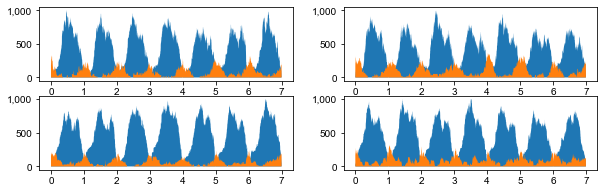

In [5]:
    #---------------------------------------------------------------------------------------------------------#
    # Display weekly EV number profiles for different seasons.
    #---------------------------------------------------------------------------------------------------------#
    from matplotlib.ticker import MultipleLocator
    weekdays = ['Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.']
    # Initiate figure setting.
    f_size = 8
    plt.rcParams['font.family'] = 'Arial'
    font = {'size': f_size} 
    font2 = {'size': f_size-2}
    fx, fy = 2, 2
    fig = plt.figure(figsize=(10, 3))
    # Build axes.
    ax1 = fig.add_subplot(fx, fy, 1)
    ax2 = fig.add_subplot(fx, fy, 2)
    ax3 = fig.add_subplot(fx, fy, 3)
    ax4 = fig.add_subplot(fx, fy, 4)
    # Plot profiles.
    for ax, x, y, sea, figorder in zip([ax1, ax2, ax3, ax4], [x1, x2, x3, x4], [y1, y2, y3, y4], 
                                       ['Spring', 'Summer', 'Autumn', 'Winter'], ['a', 'b', 'c', 'd']):
        ax.fill_between(np.arange(0, 1440*7)/1440, 1000 * x / x.max())
        ax.fill_between(np.arange(0, 1440*7)/1440, 1000 * y / x.max())
        ratio = y.mean()/x.mean()
        ax.set_yticklabels(['{:,.0f}'.format(k) for k in ax.get_yticks()])

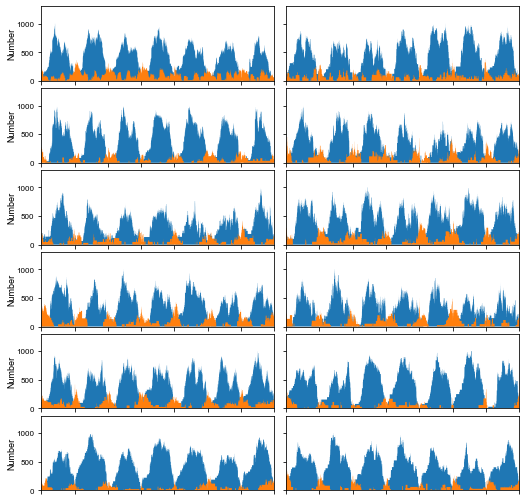

In [6]:
    #---------------------------------------------------------------------------------------------------------#
    # Display EV number profiles for 12 months.
    # The temporal resolution is controlled to be 1 min.
    # The number of an EV group is controlled to be 1000.
    #---------------------------------------------------------------------------------------------------------#
    weekdays = ['Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.']
    # Configure the chart.
    f_size = 9
    plt.rcParams['font.family'] = 'Arial'
    font = {'size': f_size} 
    font2 = {'size': f_size-2}
    fig = plt.figure(figsize=(7.2, 7))
    plt.subplots_adjust(left=0.068, bottom=0.03, right=0.99, top=0.99, wspace=0.05, hspace=0.1)
    fy, fx, ii = 2, 12/fy, 0
    for mon in np.arange(1, 13, 1):
        ii = ii + 1
        ax = fig.add_subplot(fx, fy, ii)
        y_drv = drv_week_num_mean_arr_bj[mon-1, :]
        y_chg = chg_week_num_mean_arr_bj[mon-1, :]
        # The number of an EV group is controlled to be 1000.
        ax.fill_between(np.arange(0, 1440*7)/1440, 1000 * y_drv/y_drv.max())
        ax.fill_between(np.arange(0, 1440*7)/1440, 1000 * y_chg/y_drv.max())
        # Set up axes parameters.
        ax.set_ybound(0, 1300)
        ax.set_xbound(0, 7)
        ax.tick_params(labelsize=f_size-1, direction='out')
        ax.set_xticklabels([])
        ax.set_ylabel('Number', font, labelpad=0)
        if mon not in np.arange(1, 13, 2):
            ax.set_yticklabels([])
            ax.set_ylabel('', font, labelpad=0)

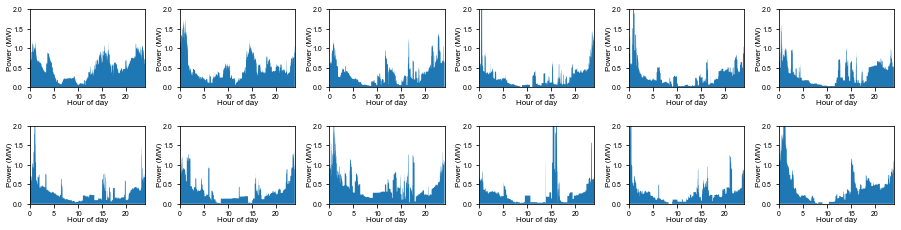

In [7]:
    #-------------------------------------------------------------
    # Process and display EV charging profiles for 12 months.
    # The temporal resolution is controlled to be 1 min.
    # The number of EV groups is controlled to be 1000.
    #---------------------------------------------------------------------------------------------------------#
    # Configure the chart.
    f_size = 8
    plt.rcParams['font.family'] = 'Arial'
    font = {'size': f_size} 
    fig = plt.figure(figsize=(12, 3))
    plt.subplots_adjust(left=0, bottom=0.1, right=1, top=1, wspace=0.3, hspace=0.5)
    fx, fy, ii = 2, 6, 0
    # Construct dataframe to record lines.
    chg_power_perCar_perDay_cum = pd.DataFrame()
    for mon in np.arange(1, 13, 1):
        ii = ii + 1
        ax = fig.add_subplot(fx, fy, ii)
        # Make a selection for designated months.
        data_bj_chg_mon = data_bj_chg.loc[data_bj_chg.start_time_dt.dt.month == mon, :]
        chg_power_perCar_perDay = mon_chg_power(data_bj_chg_mon)
        p = chg_power_perCar_perDay.mean()
        ax.fill_between(np.arange(0, 1440)/60, chg_power_perCar_perDay)
        # Set up axes parameters.
        ax.set_xbound(0, 24)
        ax.set_ybound(0, 2)
        ax.tick_params(labelsize=f_size-1)
        ax.set_ylabel('Power (MW)', font, labelpad=0)
        ax.set_xlabel('Hour of day', font, labelpad=0)